<a href="https://colab.research.google.com/github/Computational-Tools-in-DS-G42/footballer-profiler-AI/blob/trang/player_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Player Recommendation using LSH

---



## Import libraries and data

In [1]:
!pip install datasketch

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasketch import MinHashLSH, MinHash
from types import SimpleNamespace



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 4.2 MB/s eta 0:00:00


In [2]:
url = "https://raw.githubusercontent.com/Computational-Tools-in-DS-G42/datasets/main/data.csv"
init_df = pd.read_csv(url, encoding="latin1", sep=",")

## Finding Similar Players using LSH (Locality-Sensitive Hashing)

### Data Process

In [3]:
# Removing some of the columns that distors the similar players
cols_to_drop = ["club", "motm", "offsides_won", "league",  "fee", "traded", "club_position", "season", 'apps', 'age', 'mins',]
df_clean = init_df.drop(columns=cols_to_drop)
# Removing duplicate players
df_clean = df_clean.drop_duplicates(subset='name', keep='first')
df_clean = df_clean.reset_index(drop=True)


In [4]:
# Converting into float
cols = [ 'goals', 'assists', 'yel',
       'red', 'shots', 'ps%', 'aerials_won', 'tackles', 'interceptions',
       'fouls', 'clearances', 'dribbled', 'blocks', 'own_goals', 'key_passes',
       'dribblings', 'fouled', 'offsides', 'dispossed', 'bad_controls',
       'avg_passes', 'crosses', 'long_passes', 'through_passes']

for curr in cols:
  df_clean[curr] = pd.to_numeric(df_clean[curr], errors='coerce').fillna(0)

df_clean[cols] = df_clean[cols].astype(float)

### Locality-sensive Hashing (LSH)

In [5]:
# All numerical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.difference(["name"]).tolist()
# Non-numerical column
categorical_cols = ["position"]

range = 5
# Converts each player row into tokens
def make_tokens(row):
    tokens = {f"{c}={row[c]}" for c in categorical_cols}
    tokens |= {f"{c}={int(row[c]//range*range)}" for c in numeric_cols}
    return tokens

token_sets = [make_tokens(r) for _, r in df_clean.iterrows()]


# Build LSH index DOTO: You could also make it a method if you like
lsh, mhashes = MinHashLSH(threshold=0.3, num_perm=64), []
for i, s in enumerate(token_sets):
    m = MinHash(num_perm=64)
    for t in s: m.update(str(t).encode("utf8"))
    lsh.insert(str(i), m); mhashes.append(m)


In [6]:
# Method to find similar players
def find_similar_players_lsh(player_idx, k=5):
  i = player_idx
  ids = [int(j) for j in lsh.query(mhashes[i])]
  sims = [(j, len(token_sets[i]&token_sets[j])/len(token_sets[i]|token_sets[j])) for j in ids if j!=i]
  sims = sorted(sims, key=lambda x: x[1], reverse=True)[:k]

  # Building a data frame
  similar_df = df_clean.loc[[j for j, _ in sims]].copy()
  similar_df['similarity'] = [s for _, s in sims]
  similar_df.reset_index(drop=True, inplace=True)



  target_player = SimpleNamespace(
    name=df_clean.loc[i, 'name'],
    pos=df_clean.loc[i, 'position'],
    rating=df_clean.loc[i, 'rating']
)
  return similar_df, target_player


In [18]:
player_ind_to_quary = 60
num_sim_player = 5
sim_df, target = find_similar_players_lsh(player_ind_to_quary, num_sim_player)

In [19]:
sim_df.head(num_sim_player)

,name,position,goals,assists,yel,red,shots,ps%,aerials_won,rating,...,dribblings,fouled,offsides,dispossed,bad_controls,avg_passes,crosses,long_passes,through_passes,similarity
0,Marek Hamsik,FW,12.0,5.0,1.0,0.0,2.4,83.5,0.2,7.29,...,0.8,0.7,0.2,1.2,0.0,42.5,1.2,2.2,0.5,0.925926
1,Mirko Vucinic,FW,14.0,6.0,3.0,0.0,2.9,72.5,0.6,7.55,...,1.8,1.9,1.1,3.1,0.0,24.0,0.4,0.7,0.3,0.925926
2,Ivica Olic,FW,11.0,6.0,1.0,0.0,2.2,72.4,0.2,7.13,...,0.6,0.8,1.1,1.9,0.0,12.1,0.5,0.2,0.0,0.925926
3,Lois Diony,FW,11.0,8.0,2.0,1.0,1.7,72.4,1.0,6.91,...,1.5,1.5,0.6,2.7,3.1,18.2,0.4,0.3,0.0,0.925926
4,Ollie Watkins,FW,14.0,5.0,2.0,1.0,2.6,71.5,3.7,7.18,...,1.1,1.3,0.8,2.3,3.1,21.7,0.1,0.2,0.0,0.925926


### Visual Graphs

In [10]:
def plot_similar_players(sim_df, target):

    names = sim_df['name']
    ratings = sim_df['rating']
    positions = sim_df['position']
    scores = sim_df['similarity']

    plt.figure(figsize=(8, 6))
    cmap = plt.cm.viridis
    sc = plt.scatter(scores, ratings, c=ratings, cmap=cmap,
                     s=100, edgecolor='black', alpha=0.8)

    for name, pos, x, y in zip(names, positions, scores, ratings):
        plt.text(x + 0.001, y + 0.004, f"{name} ({pos})",
                 fontsize=8, ha='left', va='bottom', color='black', alpha=0.8)

    plt.scatter(1.0, target.rating, color='red', s=200, edgecolor='black',
                label=f"{target.name} ({target.pos}) [Target]")
    plt.text(1.0 + 0.001, target.rating + 0.004, f"{target.name} ({target.pos})",
             fontsize=8, fontweight='bold', color='red', ha='left')

    cbar = plt.colorbar(sc)
    cbar.set_label('Rating', rotation=270, labelpad=20)
    plt.title("Similarity Score vs Player Rating", fontsize=18, fontweight='bold')
    plt.xlabel("Similarity Score", fontsize=14, fontweight='bold')
    plt.ylabel("Player Rating", fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
    plt.tight_layout()
    plt.show()


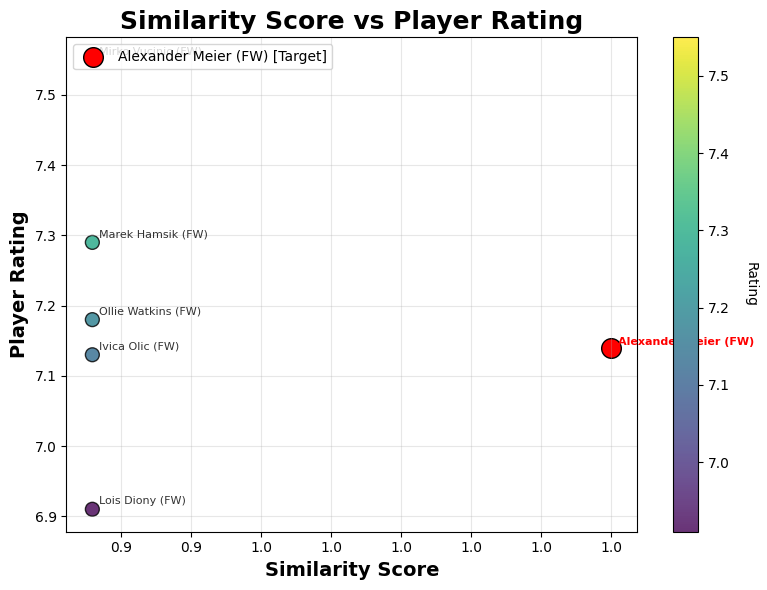

In [20]:
plot_similar_players(sim_df, target)

**Important:** Rating is just one dimension, there are more important attributes for finding similar players such as the position, play style, and so on. Moreover, I think rating should not be included at all as it's just from one perticular season. In other words, it's not an overall rating of whole career, so comparison against rating does not make sense.

## Your old code for the graph

In [12]:
# def visualize_similar_players(results, query_player_name, n_similar=10):

#     # Extract data (excluding query player)
#     similar_df = results.iloc[1:].copy()

#     if len(similar_df) == 0:
#         print("No similar players to visualize.")
#         return

#     # Create figure with single plot
#     fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#     fig.suptitle(f'Similar Players Analysis: {query_player_name}',
#                  fontsize=18, fontweight='bold', y=0.98)

#     # Scatter Plot - Similarity vs Rating
#     scatter = ax.scatter(similar_df['similarity_score'], similar_df['rating'],
#                          s=100, alpha=0.6, c=similar_df['rating'],
#                          cmap='viridis', edgecolors='black', linewidth=1.5)
#     ax.set_xlabel('Similarity Score', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Player Rating', fontsize=12, fontweight='bold')
#     ax.set_title('Similarity Score vs Player Rating', fontsize=14, fontweight='bold')
#     ax.grid(alpha=0.3)

#     # Add player names as annotations
#     for idx, row in similar_df.iterrows():
#         ax.annotate(row['name'],
#                     (row['similarity_score'], row['rating']),
#                     xytext=(5, 5), textcoords='offset points',
#                     fontsize=8, alpha=0.7)

#     # Add colorbar
#     plt.colorbar(scatter, ax=ax, label='Rating')

#     plt.tight_layout()
#     plt.show()

#     return fig


In [13]:
# def display_similar_players(player_name, n_similar=10, show_performance=True, show_graph=True,
#                             lsh=None, minhash_list=None, X_data=None, df_data=None,
#                             player_name_to_idx_map=None):

#     results, exec_time, mem_usage = find_similar_players_lsh(
#         player_name, n_similar=n_similar, lsh=lsh, minhash_list=minhash_list,
#         X_data=X_data, df_data=df_data, player_name_to_idx_map=player_name_to_idx_map)

#     query_player = results.iloc[0]

#     print("\n")
#     print(f"Query Player: {query_player['name']} ({query_player['position']})")
#     if 'cluster_name' in results.columns:
#         print(f"Cluster: {query_player.get('cluster_name', 'N/A')}")
#     print(f"Rating: {query_player['rating']:.2f}")
#     print(f"Top {n_similar} Similar Players (LSH):")
#     print(f"{'Rank':<5} {'Name':<30} {'Position':<10} {'Rating':<10} {'Similarity':<12}")

#     for idx, row in results.iloc[1:].iterrows():
#         similarity_score = row['similarity_score']
#         rank = idx
#         print(f"{rank:>3}. {row['name']:<30} {row['position']:<10} "
#                 f"{row['rating']:>8.2f}  {similarity_score:>10.4f}")

#     if show_performance:
#         print("Performance Metrics:")
#         print(f"  Execution Time: {exec_time*1000:.2f} ms")
#         print(f"  Memory Usage: {mem_usage:.2f} MB")

#     if show_graph:
#         visualize_similar_players(results, query_player['name'], n_similar=n_similar)

#     return results

### **Sample**


In [14]:
# player_name = "Manuel Neuer"
# n_similar = 10
# similar_players = display_similar_players(
#     player_name,
#     n_similar=n_similar,
#     show_performance=True,
#     show_graph=True,
#     lsh=lsh_index,
#     minhash_list=minhash_list,
#     X_data=X_full_scaled,
#     df_data=df_full,
#     player_name_to_idx_map=player_name_to_idx)

In [15]:
#Deleteme
# def prepare_similarity_data(df_train, df_unseen, feature_names, scaler):
#     # Prepare the full dataset for similarity search
#     df_full = pd.concat([df_train, df_unseen], ignore_index=True)

#     # Get feature vectors for all players
#     X_full = df_full[feature_names]
#     X_full_scaled = scaler.transform(X_full)

#     # Create a mapping of player names to indices
#     player_name_to_idx = {name: idx for idx, name in enumerate(df_full['name'])}

#     print(f"Total players in dataset: {len(df_full)}")
#     print(f"Feature dimensions: {X_full_scaled.shape[1]}")

#     return df_full, X_full_scaled, player_name_to_idx

In [16]:
# def find_similar_players_lsh(player_name, n_similar, lsh, minhash_list,
#                              X_data, df_data, player_name_to_idx_map,
#                              refine_with_cosine=True):

#     start_time = time.time()
#     tracemalloc.start()

#     # Find the player index
#     if player_name not in player_name_to_idx_map:
#         matching_names = [name for name in player_name_to_idx_map.keys()
#                          if player_name.lower() in name.lower()]
#         if not matching_names:
#             raise ValueError(f"Player '{player_name}' not found in dataset.")
#         elif len(matching_names) > 1:
#             print(f"Multiple matches found: {matching_names}")
#             print(f"Using first match: {matching_names[0]}")
#             player_name = matching_names[0]
#         else:
#             player_name = matching_names[0]

#     player_idx = player_name_to_idx_map[player_name]
#     player_minhash = minhash_list[player_idx]
#     player_vector = X_data[player_idx:player_idx+1]
#     player_row = df_data.iloc[player_idx]

#     # Query LSH for candidate similar players
#     candidate_indices = [int(idx) for idx in lsh.query(player_minhash) if int(idx) != player_idx]

#     if len(candidate_indices) == 0:
#         sample_size = min(1000, len(X_data))
#         sample_indices = np.random.choice(len(X_data), sample_size, replace=False)
#         candidate_indices = [idx for idx in sample_indices if idx != player_idx]
#         refine_with_cosine = True

#     if refine_with_cosine and len(candidate_indices) > 0:
#         candidate_vectors = X_data[candidate_indices]
#         similarities = cosine_similarity(player_vector, candidate_vectors)[0]

#         # Get top N similar players
#         top_candidate_idx = np.argsort(similarities)[::-1][:n_similar]
#         top_indices = [candidate_indices[i] for i in top_candidate_idx]
#         top_similarities = similarities[top_candidate_idx]
#     else:
#         # Use Jaccard similarity from MinHash directly
#         similarities = []
#         for idx in candidate_indices[:n_similar*2]:
#             jaccard = player_minhash.jaccard(minhash_list[idx])
#             similarities.append((idx, jaccard))
#         similarities.sort(key=lambda x: x[1], reverse=True)
#         top_indices = [idx for idx, _ in similarities[:n_similar]]
#         top_similarities = [sim for _, sim in similarities[:n_similar]]

#     # Create results dataframe
#     if len(top_indices) > 0:
#         results = df_data.iloc[top_indices][['name', 'position', 'rating']].copy()
#         results['similarity_score'] = top_similarities

#         # Add cluster information if available
#         if 'cluster' in df_data.columns:
#             results['cluster'] = df_data.iloc[top_indices]['cluster'].values
#             if 'cluster_name' in df_data.columns:
#                 results['cluster_name'] = df_data.iloc[top_indices]['cluster_name'].values
#     else:
#         results = pd.DataFrame(columns=['name', 'position', 'rating', 'similarity_score'])

#     # Add query player info
#     query_info = pd.DataFrame({
#         'name': [player_name],
#         'position': [player_row['position']],
#         'rating': [player_row['rating']],
#         'similarity_score': [1.0]
#     })
#     if 'cluster' in df_data.columns:
#         query_info['cluster'] = [player_row.get('cluster', 'N/A')]
#         if 'cluster_name' in df_data.columns:
#             query_info['cluster_name'] = [player_row.get('cluster_name', 'N/A')]

#     execution_time = time.time() - start_time
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     memory_usage = peak / 1024 / 1024  # Convert to MB

#     results = pd.concat([query_info, results], ignore_index=True)
#     return results, execution_time, memory_usage


In [17]:
# def build_lsh_index(X_data, threshold=0.3, num_perm=128):
#   for i, s in enumerate(token_sets):
#     m = MinHash(num_perm=64)
#     for t in s: m.update(str(t).encode("utf8"))
#     lsh.insert(str(i), m); mhashes.append(m)